
=== Analyzing for katz centrality ===


Processing graphs for katz: 100%|██████████| 31/31 [00:11<00:00,  2.65it/s]



=== Analyzing for harmonic centrality ===


Processing graphs for harmonic: 100%|██████████| 31/31 [00:00<00:00, 45.70it/s]



=== Analyzing for percolation centrality ===


Processing graphs for percolation: 100%|██████████| 31/31 [00:01<00:00, 26.40it/s]



=== Analyzing for betweenness centrality ===


Processing graphs for betweenness: 100%|██████████| 31/31 [00:01<00:00, 16.37it/s]



=== Analyzing for closeness centrality ===


Processing graphs for closeness: 100%|██████████| 31/31 [00:00<00:00, 35.28it/s]



=== Analyzing for eigenvector centrality ===


Processing graphs for eigenvector: 100%|██████████| 31/31 [00:00<00:00, 42.88it/s]



=== SUMMARY ===
Centrality      Avg Gamma  Avg Distance
----------------------------------------
katz            0.0903     0.409383    
harmonic        0.1065     0.431004    
percolation     0.0935     0.417309    
betweenness     0.1274     0.397921    
closeness       0.0323     0.445722    
eigenvector     0.0839     0.347918    


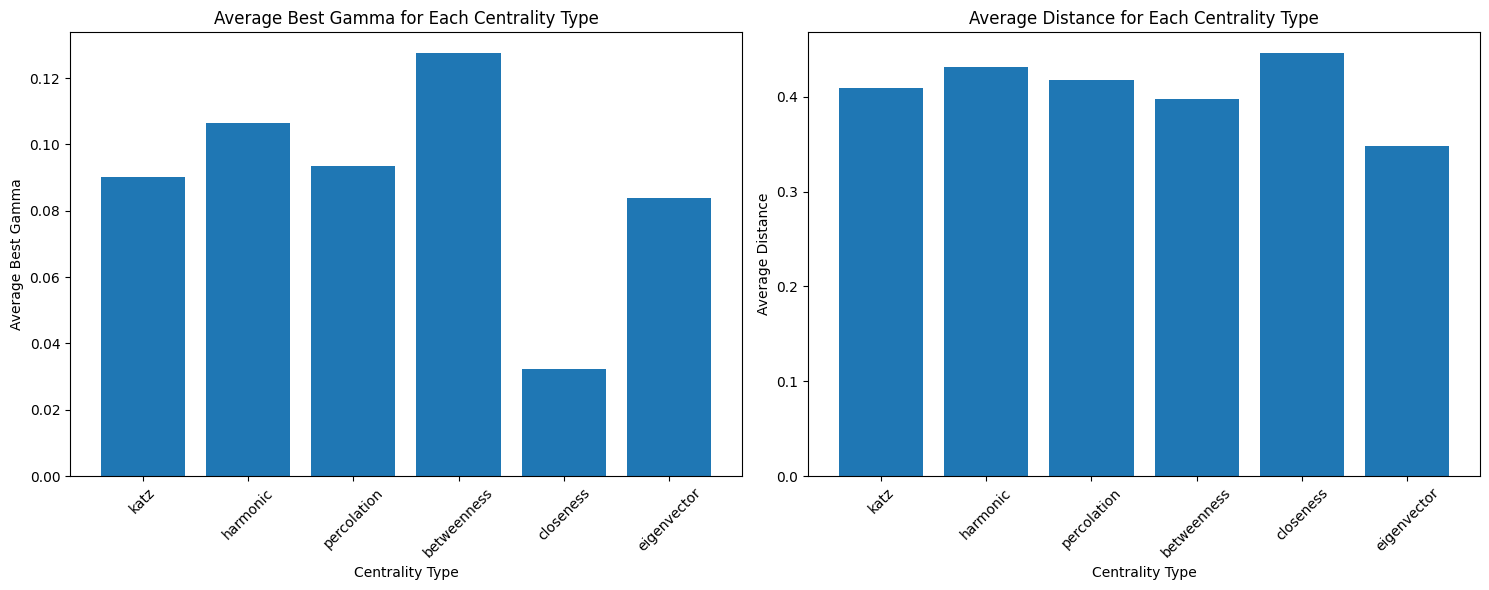

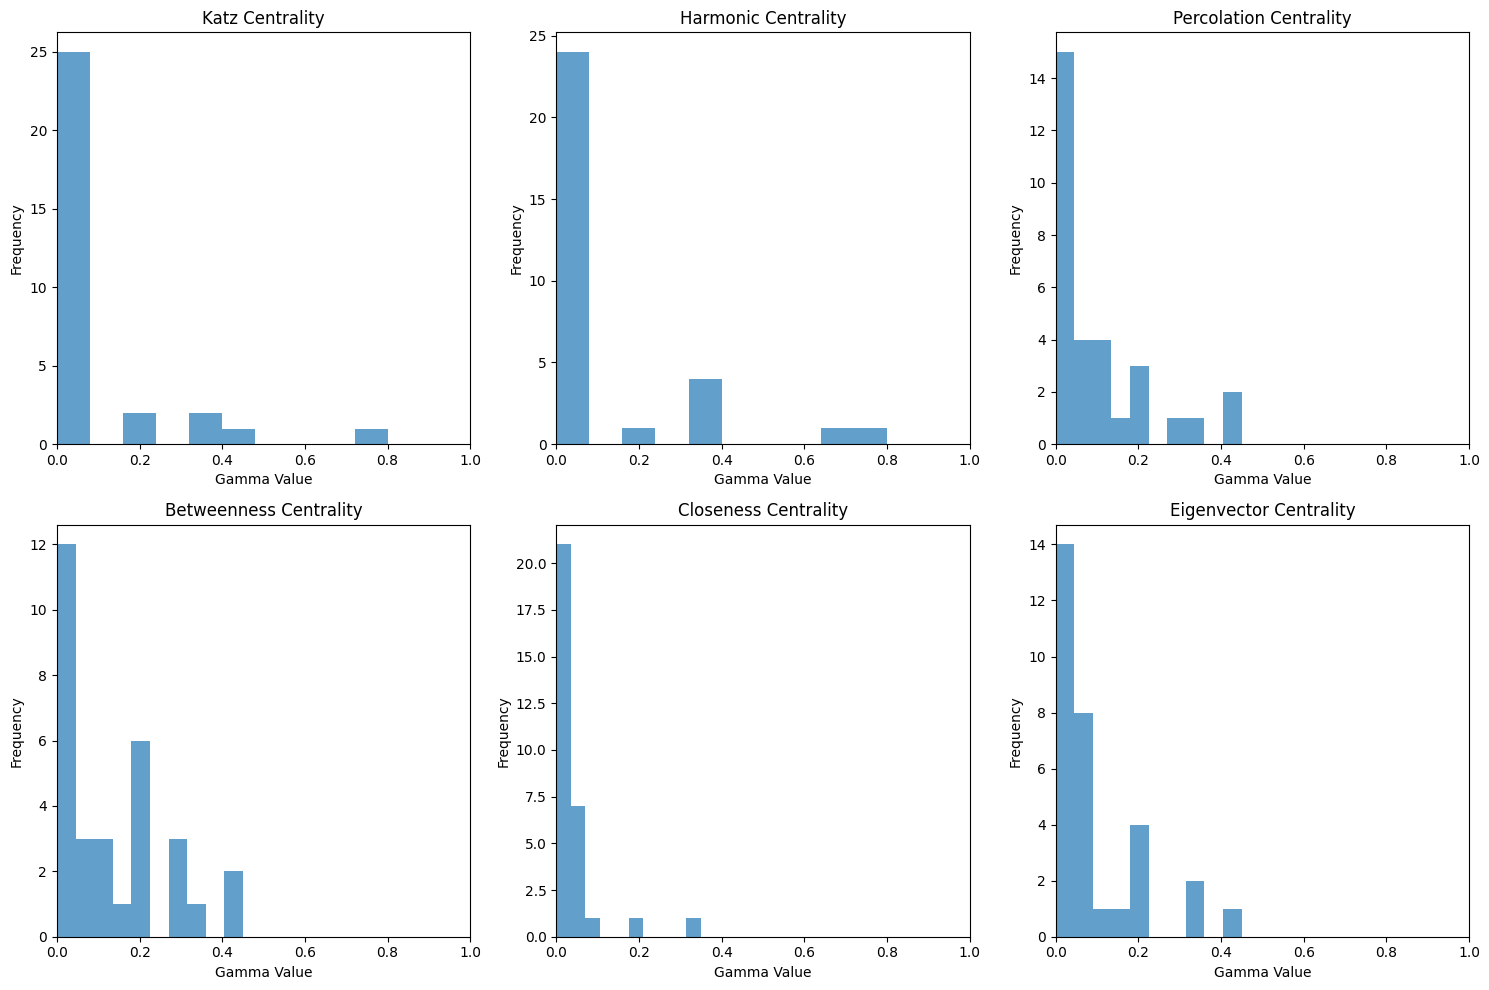

In [1]:
import networkx as nx
import numpy as np
from scipy.spatial.distance import euclidean
import matplotlib.pyplot as plt
from tqdm import tqdm

def normalize_centrality(centrality):
    """Normalize centrality vector to have unit length"""
    norm = np.linalg.norm(centrality)
    return centrality / norm if norm > 0 else centrality

def compute_centrality(G, centrality_type):
    """Compute different types of centrality for a graph"""
    if centrality_type == 'eigenvector':
        if nx.is_directed(G):
            A = nx.to_numpy_array(G).T
        else:
            A = nx.to_numpy_array(G)

        eigenvalues, eigenvectors = np.linalg.eig(A)
        max_index = np.argmax(np.real(eigenvalues))
        centrality = np.real(eigenvectors[:, max_index])

        if np.sum(centrality) < 0:
            centrality = -centrality

    elif centrality_type == 'katz':
        try:
            # Use NetworkX's implementation with appropriate parameters
            katz_centrality = nx.katz_centrality(G, alpha=0.1, beta=1.0, max_iter=1000, tol=1e-6)
            centrality = np.array([katz_centrality[node] for node in G.nodes()])
        except:
            # Fallback if Katz centrality fails to converge
            centrality = np.ones(len(G.nodes())) / len(G.nodes())

    elif centrality_type == 'harmonic':
        harmonic_centrality = nx.harmonic_centrality(G)
        centrality = np.array([harmonic_centrality[node] for node in G.nodes()])

    elif centrality_type == 'percolation':
        # Assign random percolation states (between 0 and 1) to nodes
        percolation_states = {node: np.random.random() for node in G.nodes()}
        try:
            percolation_centrality = nx.percolation_centrality(G, states=percolation_states)
            centrality = np.array([percolation_centrality[node] for node in G.nodes()])
        except:
            # Fallback if percolation centrality fails
            centrality = np.ones(len(G.nodes())) / len(G.nodes())

    elif centrality_type == 'betweenness':
        centrality = np.array(list(nx.betweenness_centrality(G).values()))

    elif centrality_type == 'closeness':
        centrality = np.array(list(nx.closeness_centrality(G).values()))

    return normalize_centrality(centrality)

def compute_inflow_outflow_matrices(G):
    """Compute inflow and outflow matrices as defined in the paper"""
    n = len(G.nodes())
    A_in = np.zeros((n, n))
    A_out = np.zeros((n, n))

    # Get in-degrees and out-degrees
    in_degrees = dict(G.in_degree())
    out_degrees = dict(G.out_degree())

    # Create mapping from node to index
    node_to_index = {node: i for i, node in enumerate(G.nodes())}

    # Compute inflow matrix
    for u in G.nodes():
        u_idx = node_to_index[u]
        neighbors = list(G.successors(u))

        if neighbors:
            denominator = sum(in_degrees[v] for v in neighbors)
            for v in neighbors:
                v_idx = node_to_index[v]
                if denominator > 0:
                    A_in[u_idx, v_idx] = in_degrees[v] / denominator

    # Compute outflow matrix
    for u in G.nodes():
        u_idx = node_to_index[u]
        predecessors = list(G.predecessors(u))

        if predecessors:
            denominator = sum(out_degrees[v] for v in predecessors)
            for v in predecessors:
                v_idx = node_to_index[v]
                if denominator > 0:
                    A_out[u_idx, v_idx] = out_degrees[v] / denominator

    return A_in, A_out

def compute_bim_centrality(G, gamma, transition_func='linear', max_iter=100, tol=1e-6):
    """Compute BIM centrality for a given gamma and transition function"""
    n = len(G.nodes())
    A_in, A_out = compute_inflow_outflow_matrices(G)

    # Combine inflow and outflow matrices
    A_combined = gamma * A_in + (1 - gamma) * A_out

    # Initialize centrality vector
    M = np.ones(n) / n

    # Damping factor (as used in PageRank)
    alpha = 0.85

    # Power iteration
    for _ in range(max_iter):
        M_new = alpha * np.dot(A_combined.T, M) + (1 - alpha) / n

        # Apply transition function
        if transition_func == 'linear':
            M_next = M_new
        elif transition_func == 'softmax':
            M_next = np.exp(M_new) / np.sum(np.exp(M_new))
        elif transition_func == 'smoothstep':
            M_next = (3 - 2 * M_new) * M_new ** 2
        elif transition_func == 'inverted_smoothstep':
            M_next = M_new * (2 * M_new ** 2 - 3 * M_new + 2)
        else:
            M_next = M_new

        # Check for convergence
        if np.linalg.norm(M_next - M) < tol:
            break

        M = M_next

    return normalize_centrality(M)

# Create a set of 30 diverse graphs
graphs = [
    nx.karate_club_graph(),
    nx.davis_southern_women_graph(),
    nx.florentine_families_graph(),
    nx.les_miserables_graph(),
    nx.windmill_graph(4, 5),
    nx.erdos_renyi_graph(50, 0.3),
    nx.barabasi_albert_graph(50, 2),
    nx.watts_strogatz_graph(50, 4, 0.3),
    nx.random_lobster(50, 0.7, 0.7),
    nx.erdos_renyi_graph(60, 0.25),
    nx.barabasi_albert_graph(60, 3),
    nx.watts_strogatz_graph(60, 5, 0.2),
    nx.random_regular_graph(3, 50),
    nx.random_geometric_graph(50, 0.3),
    nx.dorogovtsev_goltsev_mendes_graph(4),
    nx.gnm_random_graph(40, 60),
    nx.erdos_renyi_graph(70, 0.2),
    nx.barabasi_albert_graph(70, 4),
    nx.watts_strogatz_graph(70, 6, 0.1),
    nx.random_regular_graph(4, 60),
    nx.random_geometric_graph(60, 0.25),
    nx.erdos_renyi_graph(80, 0.15),
    nx.barabasi_albert_graph(80, 5),
    nx.watts_strogatz_graph(80, 7, 0.05),
    nx.random_regular_graph(5, 70),
    nx.random_geometric_graph(70, 0.2),
    nx.erdos_renyi_graph(90, 0.1),
    nx.barabasi_albert_graph(90, 6),
    nx.watts_strogatz_graph(90, 8, 0.01),
    nx.random_regular_graph(6, 80),
    nx.random_geometric_graph(80, 0.15)
]

# Convert all graphs to directed for consistency
graphs = [G.to_directed() if not nx.is_directed(G) else G for G in graphs]

# Define centrality types to compare
centrality_types = ['katz', 'harmonic', 'percolation', 'betweenness', 'closeness', 'eigenvector']

# For each centrality type, find the best gamma for each graph
results = {}

for centrality_type in centrality_types:
    print(f"\n=== Analyzing for {centrality_type} centrality ===")

    # For each graph, find the best gamma
    gamma_values = np.linspace(0, 1, 21)  # 0.0, 0.05, 0.1, ..., 1.0
    best_gammas = []
    best_distances = []

    for i, G in enumerate(tqdm(graphs, desc=f"Processing graphs for {centrality_type}")):
        # Compute target centrality
        target_centrality = compute_centrality(G, centrality_type)

        # Try different gamma values
        min_distance = float('inf')
        best_gamma = 0

        for gamma in gamma_values:
            bim_centrality = compute_bim_centrality(G, gamma)
            distance = euclidean(target_centrality, bim_centrality)

            if distance < min_distance:
                min_distance = distance
                best_gamma = gamma

        best_gammas.append(best_gamma)
        best_distances.append(min_distance)

    # Store results for this centrality type
    results[centrality_type] = {
        'best_gammas': best_gammas,
        'best_distances': best_distances,
        'avg_gamma': np.mean(best_gammas),
        'avg_distance': np.mean(best_distances)
    }

# Print summary
print("\n=== SUMMARY ===")
print(f"{'Centrality':<15} {'Avg Gamma':<10} {'Avg Distance':<12}")
print("-" * 40)
for centrality_type in centrality_types:
    avg_gamma = results[centrality_type]['avg_gamma']
    avg_distance = results[centrality_type]['avg_distance']
    print(f"{centrality_type:<15} {avg_gamma:<10.4f} {avg_distance:<12.6f}")

# Plot results
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Average gamma for each centrality type
avg_gammas = [results[ct]['avg_gamma'] for ct in centrality_types]
ax1.bar(centrality_types, avg_gammas)
ax1.set_xlabel('Centrality Type')
ax1.set_ylabel('Average Best Gamma')
ax1.set_title('Average Best Gamma for Each Centrality Type')
ax1.tick_params(axis='x', rotation=45)

# Average distance for each centrality type
avg_distances = [results[ct]['avg_distance'] for ct in centrality_types]
ax2.bar(centrality_types, avg_distances)
ax2.set_xlabel('Centrality Type')
ax2.set_ylabel('Average Distance')
ax2.set_title('Average Distance for Each Centrality Type')
ax2.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.savefig('bim_centrality_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

# Plot distribution of best gammas for each centrality type
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()

for i, centrality_type in enumerate(centrality_types):
    ax = axes[i]
    ax.hist(results[centrality_type]['best_gammas'], bins=10, alpha=0.7)
    ax.set_xlabel('Gamma Value')
    ax.set_ylabel('Frequency')
    ax.set_title(f'{centrality_type.capitalize()} Centrality')
    ax.set_xlim(0, 1)

plt.tight_layout()
plt.savefig('bim_gamma_distributions.png', dpi=300, bbox_inches='tight')
plt.show()